In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import scipy.spatial
import pickle

jax.config.update("jax_platform_name", "gpu")
import confirm.mini_imprint.lewis_drivers as lts
from confirm.mini_imprint import grid
import adastate
import diagnostics

In [2]:
from confirm.lewislib import lewis, batch

name = "4d_full"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [3]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
with open(f"./{name}/rerun_final.pkl", "rb") as f:
    _, S = pickle.load(f)
# load_iter = "latest"
# S, load_iter, fn = adastate.load(name, load_iter)

In [4]:
import criterion

cr = criterion.Criterion(lei_obj, P, S, D)

simulating with K=131072 and n_tiles=1 and batch_size=(1, 16384)
simulation runtime 9.946011543273926


In [5]:
cr.alpha_cost[cr.overall_tile]

0.008079156

In [6]:
cr.bias

DeviceArray(-3.17382813e-05, dtype=float64)

In [7]:
overall_lam = S.orig_lam.min()

In [8]:
worst_tile = np.array([0.53, 0.53, 0.53, -1.0])

## Tile density

In [9]:
plot_dims = [2, 3]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)

In [10]:
(2.0 / S.g.radii.min()) ** 4 * 10000 / 900e9

3127499.7412295113

In [11]:
S.g.radii[S.g.grid_pt_idx].max()

0.0625

In [12]:
S.g.radii[S.g.grid_pt_idx].min()

0.00048828125

In [13]:
(2.0 / 0.00048828) ** 4 / S.g.n_tiles / 1e6

7.287593979048665

In [14]:
S.sim_sizes.max()

524288

In [15]:
theta_tiles2 = S.g.theta_tiles.copy()
theta_tiles2[:, 2] = S.g.theta_tiles[:, 3]
theta_tiles2[:, 3] = S.g.theta_tiles[:, 2]
sym_tiles1 = np.concatenate((S.g.theta_tiles, theta_tiles2))

theta_tiles3 = sym_tiles1.copy()
theta_tiles3[:, 1] = sym_tiles1[:, 2]
theta_tiles3[:, 2] = sym_tiles1[:, 1]
all_tiles = np.concatenate((sym_tiles1, theta_tiles3))

In [16]:
all_lam = np.concatenate((S.orig_lam, S.orig_lam, S.orig_lam, S.orig_lam))

In [17]:
tree = scipy.spatial.KDTree(all_tiles)

In [18]:
nearby = tree.query_ball_point(slc.reshape((-1, 4)), 0.04)
nearby_count = [len(n) for n in nearby]

In [19]:
dist1, idx1 = tree.query(slc.reshape((-1, 4)), k=1)

In [20]:
dist, idx = tree.query(slc.reshape((-1, 4)), k=10)

In [21]:
1.0 / dist1

array([149.68968631, 183.12423246, 166.78750977, 172.98161739, 179.99398597, 156.90558894,
       184.47757859, 159.95090517, 178.17003481, 175.35021625, ...,  29.9960687 ,  31.48949299,
        28.87003729,  24.01560529,  31.12266114,  29.52460325,  23.30334001,  30.66440406,
        30.12724265,  22.60933676])

In [22]:
dist.shape

(10000, 10)

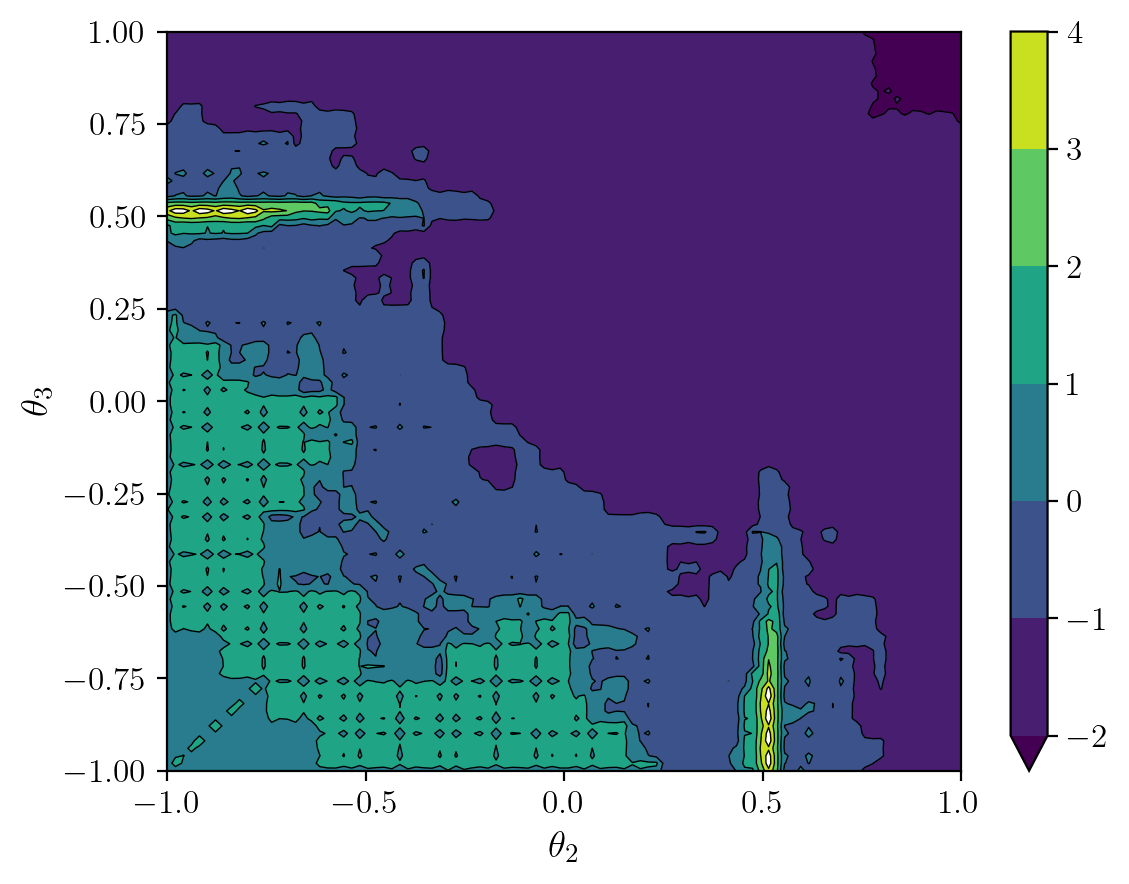

In [23]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = dist.mean(axis=1).reshape(slc.shape[:2])
z = np.tril(z)
z = z + z.T - np.diag(np.diag(z))
z = (0.01**4) / (z**4)
z = np.log10(z)
levels = np.linspace(-2, 4, 7)
cntf = plt.contourf(x, y, z, levels=levels, cmap="viridis", extend="min")
plt.contour(
    x, y, z, levels=levels, colors="k", linestyles="-", linewidths=0.5, extend="min"
)
cbar = plt.colorbar(cntf)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

/tmp/ipykernel_9465/3605867894.py:7: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


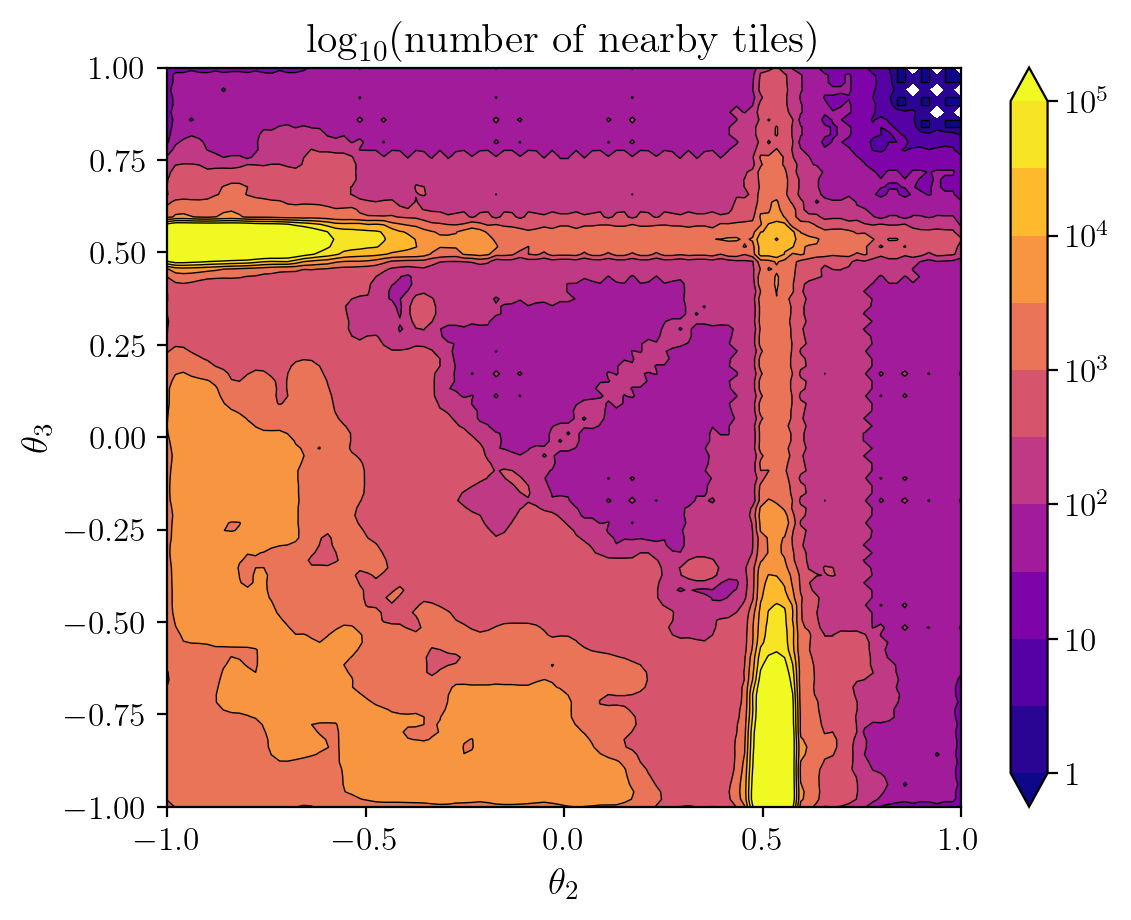

In [24]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = np.array(nearby_count).reshape(slc.shape[:2])
# z[z == 0] = z.T[z == 0]
z = np.tril(z)
z = z + z.T - np.diag(np.diag(z))
z = np.log10(z)
levels = np.linspace(0, 5, 11)
plt.title("$\log_{10}$(number of nearby tiles)")
cntf = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cntf, ticks=np.arange(6))
cbar.ax.set_yticklabels(["1", "10", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

## Type I error calculate

In [25]:
import confirm.mini_imprint.lewis_drivers as ld

In [26]:
plot_dims = [2, 3]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)
slc_ravel = slc.reshape((-1, S.g.d))
nx, ny, _ = slc.shape
eval_pts = slc.reshape((-1, 4))
null_truth = np.array([eval_pts.dot(H.n) - H.c >= 0 for H in S.g.null_hypos]).T

In [27]:
K = 32768
K * eval_pts.shape[0] * 5e-7

163.84

In [28]:
# overall_lam = 0.0625298
overall_lam = 0.05633
# typeI_sum = ld.rej_runner(
#     lei_obj,
#     np.full(eval_pts.shape[0], K),
#     overall_lam,
#     eval_pts,
#     null_truth,
#     D.unifs,
#     D.unifs_order,
# )

In [29]:
lamstar = ld.bootstrap_tune_runner(
    lei_obj,
    np.full(eval_pts.shape[0], 2**15),
    np.full(eval_pts.shape[0], 0.025),
    eval_pts,
    null_truth,
    D.unifs,
    D.bootstrap_idxs,
    D.unifs_order,
)

simulating with K=32768 and n_tiles=10000 and batch_size=(64, 1024)
simulation runtime 169.08166646957397


In [30]:
with open("4d_full/plot.pkl", "rb") as f:
    slc_load, typeI_sum = pickle.load(f)
np.testing.assert_allclose(slc, slc_load)
with open("4d_full/plot.pkl", "wb") as f:
    pickle.dump((slc, typeI_sum), f)

In [31]:
# with open("4d_full/plot_lamstar.pkl", "rb") as f:
#     slc, lamstar = pickle.load(f)
with open("4d_full/plot_lamstar.pkl", "wb") as f:
    pickle.dump((slc, lamstar), f)

In [38]:
with open("4d_full/plot_all.pkl", "wb") as f:
    pickle.dump((slc, typeI_err, lamstar, nearby_count), f)

In [39]:
typeI_err = typeI_sum / K
typeI_err[np.all(~null_truth, axis=1)] = np.nan
import confirm.mini_imprint.binomial as binomial

delta = 0.01
typeI_err, typeI_CI = binomial.zero_order_bound(typeI_sum, K, delta, 1.0)
typeI_bound = typeI_err + typeI_CI

In [40]:
import confirm.mini_imprint.bound.binomial as tiltbound

n_arm_samples = lei_obj.n_arm_samples
theta0 = eval_pts
v = eval_pts - theta0

In [41]:
fwd_solver = tiltbound.ForwardQCPSolver(n=lei_obj.n_arm_samples)


def forward_bound(theta0, vertices, f0):
    v = vertices - theta0
    q_opt = fwd_solver.solve(theta0, v, f0)
    return tiltbound.tilt_bound_fwd_tile(q_opt, n_arm_samples, theta0, v, f0)


bound = jax.jit(jax.vmap(forward_bound))(theta0, eval_pts, typeI_bound)

In [42]:
# step 1: evaluate the field of interest. if it's lambda*, we already have what
# we need. if it's TIE, we need to calculate it for the relevant tiles.

In [43]:
unplot_dims = list(set(range(S.g.d)) - set(plot_dims))

In [ ]:
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!
## See ../paper_figures/lewis.ipynb for the final paper plots!